<a href="https://colab.research.google.com/github/JungWoo-Chae/GANs-in-action/blob/master/chapter-7/7_SGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 7: Semi-Supervised GAN**


## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Hyperparameter

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

num_classes = 10

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self,  z_dim):
        super(Generator, self).__init__()
        
        self.fc = nn.Linear(z_dim, 256*7*7)
        self.g_deconv_1 = nn.Sequential(
                          nn.ConvTranspose2d(256, 128, kernel_size=3,
                                    stride= 2, padding=(3-2+1)//2,
                                    output_padding = (3-2)%2), 
                          nn.BatchNorm2d(128),
                          nn.LeakyReLU()
                          )
        self.g_deconv_2 = nn.Sequential(
                          nn.ConvTranspose2d(128, 64, kernel_size=3,
                                    stride= 1, padding=(3-1+1)//2,
                                    output_padding = (3-1)%2), 
                          nn.BatchNorm2d(64),
                          nn.LeakyReLU()
                          )
        self.g_deconv_3 = nn.Sequential(
                          nn.ConvTranspose2d(64, 1, kernel_size=3,
                                    stride= 2, padding=(3-2+1)//2,
                                    output_padding = (3-2)%2),
                          nn.Tanh()
                          )
        
        

    def forward(self, x):
        x = self.fc(x).view(-1, 256, 7, 7)
        x = self.g_deconv_1(x)
        x = self.g_deconv_2(x)
        x = self.g_deconv_3(x)
        
        return x

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.d_conv_1 = nn.Sequential(
                          nn.Conv2d(1, 32, kernel_size=3,
                                    stride=2, padding=1), 
                          nn.LeakyReLU()
                          )
        self.d_conv_2 = nn.Sequential(
                          nn.Conv2d(32, 64, kernel_size=3,
                                    stride=2, padding=1),
                          nn.BatchNorm2d(64),
                          nn.LeakyReLU()
                          )
        self.d_conv_3 = nn.Sequential(
                          nn.Conv2d(64, 128, kernel_size=3,
                                    stride=2, padding=0),
                          nn.BatchNorm2d(128),
                          nn.LeakyReLU()
                          )
        self.fc = nn.Linear(3*3*128, num_classes)
        self.do = nn.Dropout(p=0.5)
        self.sm = nn.Softmax()

    def forward(self, x, unsupervised=True):
        x = self.d_conv_1(x)
        x = self.d_conv_2(x)
        x = self.d_conv_3(x)
        x= self.do(x)
        x = x.view(-1, 128*3*3)
        x = self.fc(x)
        if unsupervised:
            x = (torch.sum(torch.exp(x), dim=1, keepdim=True) + 1.0) #
            x = 1.0 - (1.0 / x)
        else:
            x = self.sm(x)
        return x

## Build The Model

In [ ]:
discriminator = Discriminator()
discriminator = discriminator.to(device)
generator = Generator(z_dim)
generator = generator.to(device)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: 2*x-1)
    ])

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=testset.__len__(),
                                         shuffle=False, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Training

In [ ]:
losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval, semi_supervised = True):

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=4)
    train_loader_unlabeled = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=4)
    dataiter = iter(train_loader)

    real = torch.ones( batch_size, 1, device=device, dtype=torch.float)
    fake = torch.zeros( batch_size, 1, device=device, dtype=torch.float)

    criterion = nn.BCELoss()
    criterion_ce = nn.CrossEntropyLoss() 
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

    iteration = 0

    for epoch in range(10000):
        for (imgs, labels),(imgs_unlabeled, _) in zip(train_loader, train_loader_unlabeled):
            imgs = imgs.to(device)
            labels = labels.to(device)

            discriminator.train()
            generator.eval()

            outputs = discriminator(imgs, False)
            d_loss_supervised = criterion_ce(outputs, labels)
            d_optimizer.zero_grad()
            d_loss_supervised.backward()
            d_optimizer.step()



            if semi_supervised:
                imgs = imgs_unlabeled.to(device)

                z = torch.randn(batch_size, z_dim, device=device)
                gen_imgs = generator(z)

                outputs_real = discriminator(imgs)
                outputs_fake = discriminator(gen_imgs)
                d_loss_real = criterion(outputs_real, real)
                d_loss_fake = criterion(outputs_fake, fake)
                d_loss = 0.5 * (d_loss_real + d_loss_fake)

                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()

            discriminator.eval()
            generator.train()

            z = torch.randn(batch_size, z_dim, device=device)
            gen_imgs = generator(z)
            g_loss = criterion(discriminator(gen_imgs), real)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            iteration += 1
            if (iteration + 1) % sample_interval == 0:
                losses.append(d_loss_supervised.cpu().detach().numpy())
                iteration_checkpoints.append(iteration + 1)

                print("%d [D loss supervised: %f] [D loss: %f] [G loss: %f]" % (iteration + 1, d_loss_supervised, d_loss, g_loss))

                if (iteration + 1) == iterations:
                    return

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    z = torch.randn(image_grid_rows * image_grid_columns, z_dim, device=device)

    gen_imgs = generator(z).cpu().detach()

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):

            axs[i, j].imshow(gen_imgs[cnt].view(28,28), cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the Model and Inspect Output

In [ ]:
iterations = 8000
batch_size = 32
sample_interval = 800

train(iterations, batch_size, sample_interval)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


800 [D loss supervised: 1.932227] [D loss: 0.000290] [G loss: 0.004981]
1600 [D loss supervised: 1.793320] [D loss: 0.000148] [G loss: 0.004920]
2400 [D loss supervised: 1.890055] [D loss: 0.000094] [G loss: 0.000520]
3200 [D loss supervised: 1.792026] [D loss: 0.000217] [G loss: 0.016667]
4000 [D loss supervised: 1.916567] [D loss: 0.000042] [G loss: 0.000241]
4800 [D loss supervised: 1.798533] [D loss: 0.000019] [G loss: 0.000656]
5600 [D loss supervised: 1.655788] [D loss: 0.000170] [G loss: 0.000039]
6400 [D loss supervised: 1.617440] [D loss: 0.000312] [G loss: 0.000013]
7200 [D loss supervised: 1.493957] [D loss: 0.000226] [G loss: 0.000031]
8000 [D loss supervised: 1.474622] [D loss: 0.000042] [G loss: 0.000003]


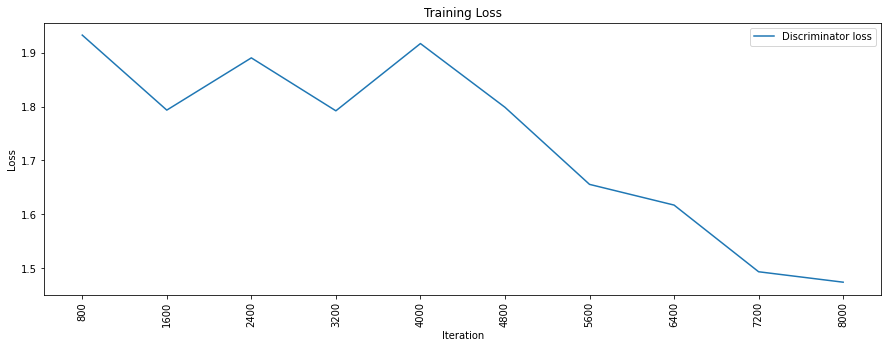

In [ ]:
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

## SGAN Classifier – Training and Test Accuracy

In [ ]:
discriminator.eval()

train_loader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                           shuffle=False, num_workers=2)

dataiter = iter(train_loader)
imgs, labels = dataiter.next()

imgs = imgs.to(device)
labels = labels.to(device)

outputs = discriminator(imgs, False)
out =  torch.argmax(outputs, dim=-1)

correct = (out == labels).sum().item()
accuracy = correct/100
print("Training Accuracy: %.2f%%" % (100 * accuracy))

Training Accuracy: 97.00%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
discriminator.eval()

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    outputs = discriminator(imgs, False)
    out =  torch.argmax(outputs, dim=-1)


correct = (out == labels).sum().item()
accuracy = correct/testset.__len__()
print("Test Accuracy: %.2f%%" % (100 * accuracy))

Test Accuracy: 93.67%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Fully-Supervised Classifier

In [ ]:
discriminator = Discriminator()
discriminator = discriminator.to(device)

In [ ]:
losses = []
iteration_checkpoints = []

def train(epochs, batch_size):

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=4)

    criterion_ce = nn.CrossEntropyLoss() 
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    iteration = 0

    for epoch in range(epochs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            discriminator.train()

            outputs = discriminator(imgs, False)
            d_loss_supervised = criterion_ce(outputs, labels)
            
            d_optimizer.zero_grad()
            d_loss_supervised.backward()
            d_optimizer.step()


        
        losses.append(d_loss_supervised.cpu().detach().numpy())
        iteration_checkpoints.append(iteration + 1)

        print("Epoch %d/%d [ loss : %f] " % (epoch + 1, epochs, d_loss_supervised))

In [ ]:
epochs = 10
batch_size = 32

train(epochs, batch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/10 [ loss : 1.562775] 
Epoch 2/10 [ loss : 1.503828] 
Epoch 3/10 [ loss : 1.474004] 
Epoch 4/10 [ loss : 1.461185] 
Epoch 5/10 [ loss : 1.523342] 
Epoch 6/10 [ loss : 1.462455] 
Epoch 7/10 [ loss : 1.492537] 
Epoch 8/10 [ loss : 1.491882] 
Epoch 9/10 [ loss : 1.523360] 
Epoch 10/10 [ loss : 1.461151] 


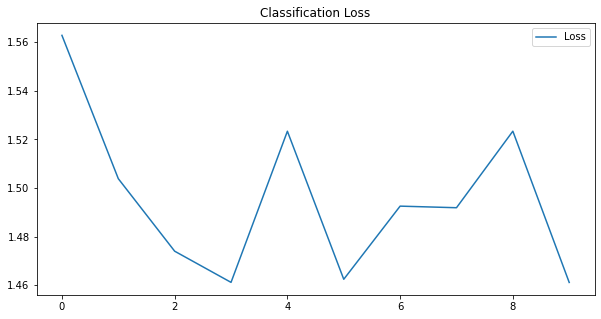

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

In [ ]:
discriminator.eval()

dataiter = iter(train_loader)
imgs, labels = dataiter.next()

imgs = imgs.to(device)
labels = labels.to(device)

outputs = discriminator(imgs, False)
out =  torch.argmax(outputs, dim=-1)

correct = (out == labels).sum().item()
accuracy = correct/100
print("Training Accuracy: %.2f%%" % (100 * accuracy))

Training Accuracy: 99.00%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
discriminator.eval()

correct = 0
for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    outputs = discriminator(imgs, False)
    out =  torch.argmax(outputs, dim=-1)
    correct += (out == labels).sum().item()
accuracy = correct/testset.__len__()
print("Test Accuracy: %.2f%%" % (100 * accuracy))

Test Accuracy: 98.79%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
